# N-Tuple Learning

Trying to implement n-tuple networks

In [156]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 Extract n-tuples

In [ ]:
for i in range(20):
    env.step(env.action_space.sample())
print(env.game)

<2048 Game: score 196 and 35 moves lead to 32 as highest tile>
[[ 0  0  2  2]
 [ 0  0  0  2]
 [ 4  2  4 16]
 [ 2  8 32  2]]


In [ ]:
[2,0], [2,1], [3,1], [3,0]

In [ ]:
env.game.grid[[2,2,3,3], [0,1,1,0]], env.game.grid[[-2,-2,-1,-1], [0,1,1,0]]

(array([2, 1, 3, 1], dtype=uint8), array([2, 1, 3, 1], dtype=uint8))

In [ ]:
def extract_tuples() -> np.ndarray:
    game = env.game
    n_tuples = []
    for i in range(game.grid.shape[0]):
        n_tuples.append(np.diff(game.grid[i,::], prepend=0))
        n_tuples.append(np.diff(game.grid[i,::-1], prepend=0))
    for i in range(game.grid.shape[1]):
        n_tuples.append(np.diff(game.grid[::,i], prepend=0))
        n_tuples.append(np.diff(game.grid[::-1,i], prepend=0))
    n_tuples.append(np.diff(game.grid[[1,1,0,0], [1,0,0,1]], prepend=0))
    n_tuples.append(np.diff(game.grid[[1,1,0,0], [-2,-1,-1,-2]], prepend=0))
    n_tuples.append(np.diff(game.grid[[-2,-2,-1,-1], [1,0,0,1]], prepend=0))
    n_tuples.append(np.diff(game.grid[[-2,-2,-1,-1], [-2,-1,-1,-2]], prepend=0))
    n_tuples.append(np.diff(game.grid[[1,0,0,1], [1,1,0,0]], prepend=0))
    n_tuples.append(np.diff(game.grid[[-2,-1,-1,-2], [1,1,0,0]], prepend=0))
    n_tuples.append(np.diff(game.grid[[1,0,0,1], [-2,-2,-1,-1]], prepend=0))
    n_tuples.append(np.diff(game.grid[[-2,-1,-1,-2], [-2,-2,-1,-1]], prepend=0))
    return (np.array(n_tuples))

extract_tuples().shape

(24, 4)

### 2 Q-Learning

In [ ]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], action_space: gym.spaces.Space,  device) -> None:
        super(DQN, self).__init__()
        self.device = device
        self.action_space = action_space
        if action_space.shape is None or len(action_space.shape) != 1:
            raise RuntimeError("The action space must provide an 1D shape as property")
        self.grid_size = grid_shape[0]*grid_shape[1]
        self.net = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(1,4)),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=24, out_features=32),
            nn.Linear(in_features=32, out_features=action_space.shape[0]),
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def predict_action(self, x: np.ndarray, mask: np.ndarray|None = None) -> tuple[list[Action|None], np.ndarray]:
        """ 
        Predict the action according to the probabilities in the grid

        Args:
            x (np.ndarray): The current state encoded as numpy objet (e.g. (4,4) game grid)
            mask (np.ndarray|None): If not None, the mask should be an 1D array of length 4 of zeros and ones.
                The model will only predict actions masked to have an 1. This can be used to filter invalid actions before
                sending the state to the model.

        Returns:
            action (Action): Predicted action using the probabilities provided by the model
            probs (np.ndarray): Probs
        
        """
        t = torch.from_numpy(x).float().to(self.device)
        while len(t.shape) < 4:
            t = t.unsqueeze(0)
        with torch.no_grad():
            q_values = self.forward(t)
        probs = nn.functional.softmax(q_values, dim=1).detach().cpu().numpy()
        if mask is not None and not mask.any():
            return [None for i in range(probs.shape[0])], probs
        return [self.action_space.sample(mask=mask, probability=probs[i]) for i in range(probs.shape[0])], probs
    
net = DQN(grid_shape=(4,4), action_space=env.action_space, device="cpu")

In [ ]:
net.predict_action(extract_tuples()[None,:,:])

([<Action.DOWN: 1>],
 array([[0.26164526, 0.26830512, 0.2406215 , 0.22942816]], dtype=float32))

In [ ]:
np.array([0,0,1,1]).any()

np.True_

In [ ]:
net.predict_action(np.array([extract_tuples()[None,:,:], extract_tuples()[None,:,:]]), mask=np.array([1,1,0,0]))

([<Action.UP: 0>, <Action.UP: 0>],
 array([[0.26164526, 0.26830512, 0.2406215 , 0.22942816],
        [0.26164526, 0.26830512, 0.2406215 , 0.22942816]], dtype=float32))

In [ ]:
t = torch.from_numpy(np.array([extract_tuples()[None,:,:], extract_tuples()[None,:,:]])).float()
print(t.shape)
net.forward(t), net.forward(t).shape
net.predict_action(np.array([extract_tuples()[None,:,:], extract_tuples()[None,:,:]]))

torch.Size([2, 1, 24, 4])


([<Action.UP: 0>, <Action.RIGHT: 3>],
 array([[0.27089733, 0.20078318, 0.1934248 , 0.33489472],
        [0.27089733, 0.20078318, 0.1934248 , 0.33489472]], dtype=float32))

In [ ]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 64

    def step(self) -> bool:
        action = self.predict()
        if action is None:
            return False
        state = self.extract_tuples()
        next_state, reward, done, truncated, info = env.step(action)
        next_state = self.extract_tuples()
        self.memory.append((state[None, :, :], action, float(reward), next_state[None, :, :], done or truncated))
        return done or truncated

    def predict(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        return self.model.predict_action(self.extract_tuples(), mask=mask)[0][0]
    
    def predict_greedy(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.extract_tuples(), mask=mask)[0][0]
    
    def get_probs(self) -> dict[Action, str]:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        probs = self.model.predict_action(self.extract_tuples(), mask=mask)[1][0]
        return {a: f"{probs[a.value]:1.3f}" + (" (invalid)" if mask[a.value] == 0 else "") for a in Action}

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0].squeeze(1)
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def extract_tuples(self) -> np.ndarray:
        game = self.env.game
        n_tuples = []
        for i in range(game.grid.shape[0]):
            n_tuples.append(np.diff(game.grid[i,::], prepend=0))
            n_tuples.append(np.diff(game.grid[i,::-1], prepend=0))
        for i in range(game.grid.shape[1]):
            n_tuples.append(np.diff(game.grid[::,i], prepend=0))
            n_tuples.append(np.diff(game.grid[::-1,i], prepend=0))
        n_tuples.append(np.diff(game.grid[[1,1,0,0], [1,0,0,1]], prepend=0))
        n_tuples.append(np.diff(game.grid[[1,1,0,0], [-2,-1,-1,-2]], prepend=0))
        n_tuples.append(np.diff(game.grid[[-2,-2,-1,-1], [1,0,0,1]], prepend=0))
        n_tuples.append(np.diff(game.grid[[-2,-2,-1,-1], [-2,-1,-1,-2]], prepend=0))
        n_tuples.append(np.diff(game.grid[[1,0,0,1], [1,1,0,0]], prepend=0))
        n_tuples.append(np.diff(game.grid[[-2,-1,-1,-2], [1,1,0,0]], prepend=0))
        n_tuples.append(np.diff(game.grid[[1,0,0,1], [-2,-2,-1,-1]], prepend=0))
        n_tuples.append(np.diff(game.grid[[-2,-1,-1,-2], [-2,-2,-1,-1]], prepend=0))
        return (np.array(n_tuples))


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, epsilon_decay=0.003)
scores = []
highest_tiles = []
move_counts = []
episode = 0

In [ ]:
agent.env.game

<2048 Game: score 0 and 0 moves lead to 2 as highest tile>
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]]

In [ ]:
agent.get_probs()

{<Action.UP: 0>: '0.233',
 <Action.DOWN: 1>: '0.253',
 <Action.LEFT: 2>: '0.269',
 <Action.RIGHT: 3>: '0.246 (invalid)'}

Episode 9313 - Score: 3052 - Highest tile: 256 - Epsilon: 0.001


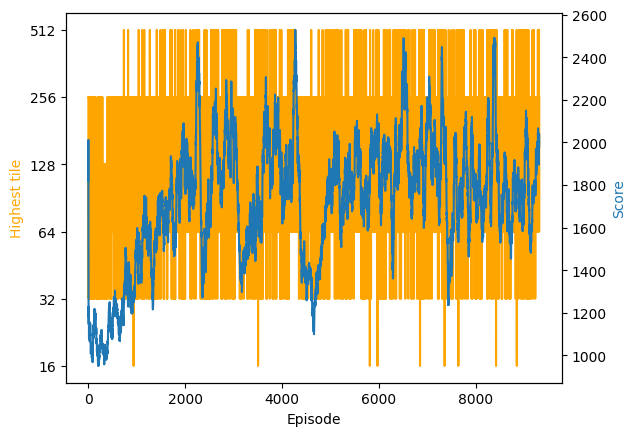

In [ ]:
for episode in range(episode, episode+1):
    obs, info = env.reset()
    done = False

    while not done:
        done = agent.step()
        agent.train_step()

    print(f"Episode {episode} - Score: {env.game.score} - Highest tile: {env.game.highest_tile()} - Epsilon: {agent.epsilon:.3f}")
    agent.decay_epsilon()

    scores.append(env.game.score)
    highest_tiles.append(env.game.highest_tile())
    move_counts.append(env.game.move_count)

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores))], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

##### Visualize tuple convolution output

In [ ]:
agent.model.forward(torch.from_numpy(np.array([[0,0,0,0], [1,2,3,4], [2,-2,2,-3]])).unsqueeze(0).unsqueeze(0).float())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 24x32)

In [ ]:
net.net[0].weight.shape

torch.Size([1, 1, 1, 4])

In [ ]:
x = extract_tuples()
t = torch.from_numpy(x).float().to("cpu").unsqueeze(0).unsqueeze(0)
net.forward(t).shape

torch.Size([1, 1, 24])

In [ ]:
x = extract_tuples()
t = torch.from_numpy(x).float().to("cpu").unsqueeze(0).unsqueeze(0)
r = net.forward(t).detach().numpy()
print(t.shape, r.shape)

torch.Size([1, 1, 24, 4]) (1, 1, 24, 1)


In [ ]:
x = extract_tuples()
t = torch.from_numpy(x).float().to("cpu").unsqueeze(0).unsqueeze(0)
r = net.forward(t).detach().numpy().squeeze(0).squeeze(0)
print(t.shape, r.shape)
print("\n".join([f"{a} ==> {b}" for a,b in zip(x,r)]))

torch.Size([1, 1, 24, 4]) (24, 1)
[0 0 1 0] ==> [0.2517364]
[ 1  0 -1  0] ==> [-0.30369097]
[0 0 0 1] ==> [0.02502185]
[ 1 -1  0  0] ==> [0.35907346]
[ 2 -1  1  2] ==> [1.316238]
[ 4 -2 -1  1] ==> [1.0948622]
[ 1  2  2 -4] ==> [-0.3291574]
[ 1  4 -2 -2] ==> [-2.1081152]
[ 0  0  2 -1] ==> [0.47845095]
[ 1  1 -2  0] ==> [-0.9664554]
[0 0 1 2] ==> [0.5847157]
[ 3 -2 -1  0] ==> [0.6973915]
[ 1 -1  2  3] ==> [1.6449509]
[ 5 -3 -2  1] ==> [1.2021995]
[ 1  0  3 -3] ==> [0.76965696]
[ 1  3 -3  0] ==> [-1.8987801]
[0 0 0 0] ==> [-0.14146781]
[0 1 0 0] ==> [-0.41102803]
[ 1  1 -1  2] ==> [-0.24027187]
[ 2  2 -3  4] ==> [-0.73228014]
[0 0 0 0] ==> [-0.14146781]
[ 1  2 -2  1] ==> [-1.069526]
[0 1 0 0] ==> [-0.41102803]
[ 2  3 -4  3] ==> [-1.5615342]


In [ ]:
net.forward(torch.from_numpy(np.array([[0,0,0,0]])).float().to("cpu"))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 4]

In [ ]:
x = extract_tuples()
t = torch.from_numpy(x).float().to("cpu")
r = net.forward(t).detach().numpy()
print("\n".join([f"{a} ==> {b}" for a,b in zip(x,r)]))

[0 0 1 0] ==> [0.9190606]
[ 1  0 -1  0] ==> [-0.37546384]
[0 0 0 1] ==> [-1.3477478]
[ 1 -1  0  0] ==> [-0.23202215]
[ 2 -1  1  2] ==> [1.0431131]
[ 4 -2 -1  1] ==> [-0.5629661]
[ 1  2  2 -4] ==> [-0.00073934]
[ 1  4 -2 -2] ==> [-0.71499085]
[ 0  0  2 -1] ==> [0.90804595]
[ 1  1 -2  0] ==> [0.84953725]
[0 0 1 2] ==> [0.94786507]
[ 3 -2 -1  0] ==> [-0.28071514]
[ 1 -1  2  3] ==> [0.2999323]
[ 5 -3 -2  1] ==> [-0.12252116]
[ 1  0  3 -3] ==> [-0.39899406]
[ 1  3 -3  0] ==> [1.2927729]
[0 0 0 0] ==> [-0.6858995]
[0 1 0 0] ==> [0.17256317]
[ 1  1 -1  2] ==> [-1.7599446]
[ 2  2 -3  4] ==> [-0.00443557]
[0 0 0 0] ==> [0.8925464]
[ 1  2 -2  1] ==> [-0.46504447]
[0 1 0 0] ==> [1.5941529]
[ 2  3 -4  3] ==> [-0.83595973]


### 3 Optimized n-tuple architecture

In [152]:
def extract_tuples() -> np.ndarray:
    game = env.game
    n_tuples = []
    for i in range(game.grid.shape[0]):
        n_tuples.append(game.grid[i,::])
        n_tuples.append(game.grid[i,::-1])
    for i in range(game.grid.shape[1]):
        n_tuples.append(game.grid[::,i])
        n_tuples.append(game.grid[::-1,i])
    n_tuples.append(game.grid[[1,1,0,0], [1,0,0,1]])
    n_tuples.append(game.grid[[1,1,0,0], [-2,-1,-1,-2]])
    n_tuples.append(game.grid[[-2,-2,-1,-1], [1,0,0,1]])
    n_tuples.append(game.grid[[-2,-2,-1,-1], [-2,-1,-1,-2]])
    n_tuples.append(game.grid[[1,0,0,1], [1,1,0,0]])
    n_tuples.append(game.grid[[-2,-1,-1,-2], [1,1,0,0]])
    n_tuples.append(game.grid[[1,0,0,1], [-2,-2,-1,-1]])
    n_tuples.append(game.grid[[-2,-1,-1,-2], [-2,-2,-1,-1]])

    n_tuples2 = []
    for nt in n_tuples:
        n_tuples2.append(np.concatenate((nt, np.diff(nt, prepend=0))))

    return (np.array(n_tuples2))

extract_tuples()

array([[ 2,  1,  3,  0,  2, -1,  2, -3],
       [ 0,  3,  1,  2,  0,  3, -2,  1],
       [ 2,  4,  2,  1,  2,  2, -2, -1],
       [ 1,  2,  4,  2,  1,  1,  2, -2],
       [ 1,  3,  7,  0,  1,  2,  4, -7],
       [ 0,  7,  3,  1,  0,  7, -4, -2],
       [ 0,  1,  0,  0,  0,  1, -1,  0],
       [ 0,  0,  1,  0,  0,  0,  1, -1],
       [ 2,  2,  1,  0,  2,  0, -1, -1],
       [ 0,  1,  2,  2,  0,  1,  1,  0],
       [ 1,  4,  3,  1,  1,  3, -1, -2],
       [ 1,  3,  4,  1,  1,  2,  1, -3],
       [ 3,  2,  7,  0,  3, -1,  5, -7],
       [ 0,  7,  2,  3,  0,  7, -5,  1],
       [ 0,  1,  0,  0,  0,  1, -1,  0],
       [ 0,  0,  1,  0,  0,  0,  1, -1],
       [ 4,  2,  2,  1,  4, -2,  0, -1],
       [ 2,  1,  0,  3,  2, -1, -1,  3],
       [ 3,  1,  0,  1,  3, -2, -1,  1],
       [ 7,  0,  0,  0,  7, -7,  0,  0],
       [ 4,  1,  2,  2,  4, -3,  1,  0],
       [ 3,  1,  0,  1,  3, -2, -1,  1],
       [ 2,  3,  0,  1,  2,  1, -3,  1],
       [ 7,  0,  0,  0,  7, -7,  0,  0]])

In [ ]:
t = torch.from_numpy(extract_tuples()).float().unsqueeze(0)
for l in t.unbind(1):
    print(l.shape, l)

torch.Size([1, 4]) tensor([[0., 0., 0., 2.]])
torch.Size([1, 4]) tensor([[2., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 1.]])
torch.Size([1, 4]) tensor([[1., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[2., 1., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 1., 2.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 1., 2., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([1, 4]) tensor([[0., 0.

In [157]:
class DQN_N_Tuple2(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], action_space: gym.spaces.Space,  device) -> None:
        super().__init__()
        self.device = device
        self.action_space = action_space
        if action_space.shape is None or len(action_space.shape) != 1:
            raise RuntimeError("The action space must provide an 1D shape as property")
        self.grid_size = grid_shape[0]*grid_shape[1]

        self.tuple_net = nn.Sequential(
            nn.Linear(in_features=8, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=3),
            nn.Tanh(),
        )
        self.tuple_net.to(self.device)

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=24*cast(nn.Linear, self.tuple_net[-2]).out_features, out_features=40),
            nn.ReLU(),
            nn.Linear(in_features=40, out_features=20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=4),
            nn.ReLU(),
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n, 24, 4) """
        x = self.tuple_net(x.reshape(-1, cast(nn.Linear, self.tuple_net[0]).in_features))
        return self.net(x.reshape(x.shape[-2]//24, 24, cast(nn.Linear, self.tuple_net[-2]).out_features))
    
    def predict_action(self, x: np.ndarray, mask: np.ndarray|None = None) -> tuple[list[Action|None], np.ndarray]:
        """ 
        Predict the action according to the probabilities in the grid

        Args:
            x (np.ndarray): The current state encoded as numpy objet (e.g. (4,4) game grid)
            mask (np.ndarray|None): If not None, the mask should be an 1D array of length 4 of zeros and ones.
                The model will only predict actions masked to have an 1. This can be used to filter invalid actions before
                sending the state to the model.

        Returns:
            action (Action): Predicted action using the probabilities provided by the model
            probs (np.ndarray): Probs
        
        """
        t = torch.from_numpy(x).float().to(self.device)
        while len(t.shape) < 3:
            t = t.unsqueeze(0)
        with torch.no_grad():
            q_values = self.forward(t)
        probs = nn.functional.softmax(q_values, dim=1).detach().cpu().numpy()
        if mask is not None and not mask.any():
            return [None for i in range(probs.shape[0])], probs
        return [self.action_space.sample(mask=mask, probability=probs[i]) for i in range(probs.shape[0])], probs
    
net = DQN_N_Tuple2(grid_shape=(4,4), action_space=env.action_space, device="cpu")

In [190]:
def test_output():
    game = env.game
    game.grid = np.array([[1,2,3,4], [0,0,4,4], [1,1,1,1], [3,1,4,2]])
    print(game)
    tuples = agent.extract_tuples()
    t = torch.from_numpy(tuples).float().unsqueeze(0)
    x: torch.Tensor = agent.model.tuple_net.forward(t.reshape(-1, cast(nn.Linear, agent.model.tuple_net[0].in_features)))
    x = x.reshape(x.shape[-2]//24, 24, agent.model.tuple_net[-2].out_features)
    print(x.shape)
    print([(a,b) for a,b in zip(tuples, x.squeeze(0).detach().numpy())])
    for a,b in zip(tuples, x.squeeze(0).detach().numpy()):
        print(f"({','.join(a[:4].astype("str"))}): [{','.join(b.astype("str"))}]" )
    x = agent.model.net.forward(x)
    print(x)

test_output()

<2048 Game: score 1292 and 127 moves lead to 128 as highest tile>
[[ 2  4  8 16]
 [ 0  0 16 16]
 [ 2  2  2  2]
 [ 8  2 16  4]]
torch.Size([1, 24, 3])
[(array([1, 2, 3, 4, 1, 1, 1, 1]), array([ 1.,  1., -1.], dtype=float32)), (array([ 4,  3,  2,  1,  4, -1, -1, -1]), array([-0.99984545, -0.9998161 ,  1.        ], dtype=float32)), (array([0, 0, 4, 4, 0, 0, 4, 0]), array([-1.        , -0.55173737,  1.        ], dtype=float32)), (array([ 4,  4,  0,  0,  4,  0, -4,  0]), array([-0.19381782, -1.        ,  1.        ], dtype=float32)), (array([1, 1, 1, 1, 1, 0, 0, 0]), array([-0.9941747, -0.3612942,  1.       ], dtype=float32)), (array([1, 1, 1, 1, 1, 0, 0, 0]), array([-0.9941747, -0.3612942,  1.       ], dtype=float32)), (array([ 3,  1,  4,  2,  3, -2,  3, -2]), array([-0.99310815,  0.8456692 ,  0.2402487 ], dtype=float32)), (array([ 2,  4,  1,  3,  2,  2, -3,  2]), array([-0.25209633, -0.99745846,  1.        ], dtype=float32)), (array([ 1,  0,  1,  3,  1, -1,  1,  2]), array([ 1.,  1., -1.]

In [178]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN_N_Tuple2(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN_N_Tuple2(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 200

    def step(self) -> bool:
        action = self.predict()
        if action is None:
            return False
        state = self.extract_tuples()
        next_state, reward, done, truncated, info = env.step(action)
        next_state = self.extract_tuples()
        self.memory.append((state[None, :, :], action, float(reward), next_state[None, :, :], done or truncated))
        return done or truncated

    def predict(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        return self.model.predict_action(self.extract_tuples(), mask=mask)[0][0]
    
    def predict_greedy(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.extract_tuples(), mask=mask)[0][0]
    
    def get_probs(self) -> dict[Action, str]:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        probs = self.model.predict_action(self.extract_tuples(), mask=mask)[1][0]
        return {a: f"{probs[a.value]:1.3f}" + (" (invalid)" if mask[a.value] == 0 else "") for a in Action}

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0].squeeze(1)
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def extract_tuples(self) -> np.ndarray:
        game = self.env.game
        n_tuples = []
        for i in range(game.grid.shape[0]):
            n_tuples.append(game.grid[i,::])
            n_tuples.append(game.grid[i,::-1])
        for i in range(game.grid.shape[1]):
            n_tuples.append(game.grid[::,i])
            n_tuples.append(game.grid[::-1,i])
        n_tuples.append(game.grid[[1,1,0,0], [1,0,0,1]])
        n_tuples.append(game.grid[[1,1,0,0], [-2,-1,-1,-2]])
        n_tuples.append(game.grid[[-2,-2,-1,-1], [1,0,0,1]])
        n_tuples.append(game.grid[[-2,-2,-1,-1], [-2,-1,-1,-2]])
        n_tuples.append(game.grid[[1,0,0,1], [1,1,0,0]])
        n_tuples.append(game.grid[[-2,-1,-1,-2], [1,1,0,0]])
        n_tuples.append(game.grid[[1,0,0,1], [-2,-2,-1,-1]])
        n_tuples.append(game.grid[[-2,-1,-1,-2], [-2,-2,-1,-1]])
        
        n_tuples2 = []
        for nt in n_tuples:
            n_tuples2.append(np.concatenate((nt, np.diff(nt, prepend=0))))

        return (np.array(n_tuples2))


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, epsilon=0.5, epsilon_decay=0.005, gamma=0.99)
scores = []
highest_tiles = []
move_counts = []
episode = -1

Episode 8096/30000 - Score: 1264 - Highest tile: 128 - Length: 130 - Epsilon: 0.001 - Average Score: 1671.122
Episode 8097/30000 - Score: 1396 - Highest tile: 128 - Length: 143 - Epsilon: 0.001 - Average Score: 1664.585
Episode 8098/30000 - Score: 688 - Highest tile: 64 - Length: 93 - Epsilon: 0.001 - Average Score: 1629.951
Episode 8099/30000 - Score: 1552 - Highest tile: 128 - Length: 161 - Epsilon: 0.001 - Average Score: 1633.171
Episode 8100/30000 - Score: 956 - Highest tile: 64 - Length: 114 - Epsilon: 0.001 - Average Score: 1628.878
Episode 8101/30000 - Score: 1992 - Highest tile: 128 - Length: 180 - Epsilon: 0.001 - Average Score: 1644.780
Episode 8102/30000 - Score: 888 - Highest tile: 64 - Length: 108 - Epsilon: 0.001 - Average Score: 1605.171
Episode 8103/30000 - Score: 1544 - Highest tile: 128 - Length: 152 - Epsilon: 0.001 - Average Score: 1607.415
Episode 8104/30000 - Score: 1388 - Highest tile: 128 - Length: 145 - Epsilon: 0.001 - Average Score: 1608.780
Episode 8105/3000

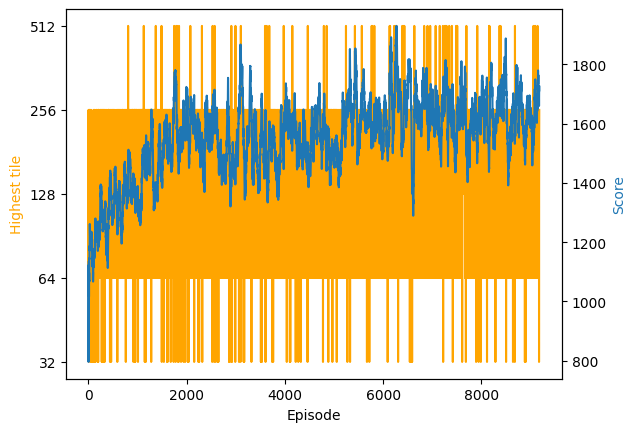

In [196]:
episode += 1
episode_cap = 30_000
try:
    for episode in range(episode, episode_cap):
        obs, info = env.reset()
        done = False

        while not done:
            done = agent.step()
            agent.train_step()

        scores.append(env.game.score)
        highest_tiles.append(env.game.highest_tile())
        move_counts.append(env.game.move_count)

        print(f"Episode {episode}/{episode_cap} - Score: {env.game.score} - Highest tile: {env.game.highest_tile()} - Length: {env.game.move_count} - Epsilon: {agent.epsilon:.3f} - Average Score: {np.mean(scores[max(0,episode-50):episode+1]):1.3f}")
        
        agent.decay_epsilon()

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

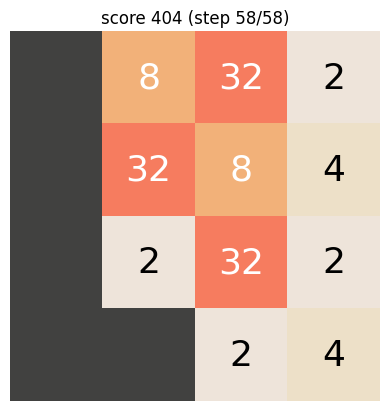

In [195]:
HTML(env.game.render_game().to_jshtml())